# Import

In [43]:
import os
import librosa
import threading
import numpy as np
import pandas as pd
import xgboost as xgb
from os.path import join
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from keras.utils import get_file
from keras.models import Input, Model
from sklearn.metrics import roc_curve, auc
from features.sampler import SSPNetSampler
from keras.utils import Sequence, plot_model
from IPython.display import SVG, Image, Audio
from keras.utils.vis_utils import model_to_dot
from keras.layers import LSTM, Dense, Merge, Reshape
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense, TimeDistributed, concatenate
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler

# Metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# To compare with sklearn model 
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Create noise data

In [69]:
NOISE = True

Add white noise to audio file

In [38]:
def mix_with_sound(x, sr, sound_path, snr):
    z, sr = librosa.core.load(sound_path, sr=sr, mono=True)
    while z.shape[0] < x.shape[0]: # loop in case noise is shorter than 
        z = np.concatenate((z, z), axis=0)
    z = z[0: x.shape[0]]
    rms_z = np.sqrt(np.mean(np.power(z, 2)))
    rms_x = np.sqrt(np.mean(np.power(x, 2)))
    snr_linear = 10 ** (snr / 20.0)
    snr_linear_factor = rms_x / rms_z / snr_linear
    y = x + z * snr_linear_factor
    rms_y = np.sqrt(np.mean(np.power(y, 2)))
    y = y * rms_x / rms_y
    return y

Choose parametr of white noise

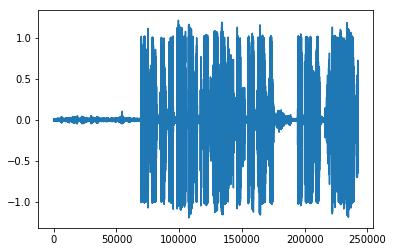

In [56]:
TEST_WAV = 'data/S0001.wav'
x, sr = librosa.core.load(TEST_WAV, mono=True)
plt.plot(x)
plt.show();
Audio(x, rate=sr)

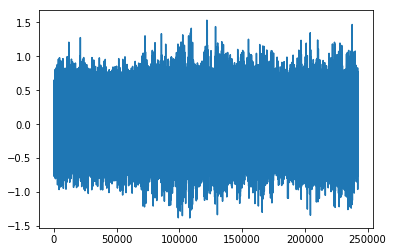

In [53]:
y = mix_with_sound(x, sr, 'white-noise.wav', -6)
plt.plot(y)
plt.show();
Audio(y, rate=sr)

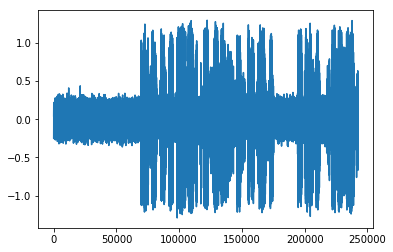

In [54]:
y = mix_with_sound(x, sr, 'white-noise.wav', 10)
plt.plot(y)
plt.show();
Audio(y, rate=sr)

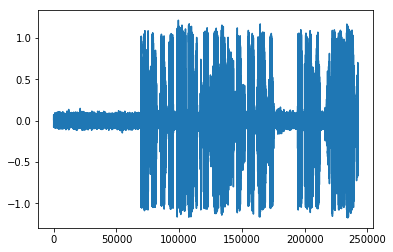

In [55]:
y = mix_with_sound(x, sr, 'white-noise.wav', 20)
plt.plot(y)
plt.show();
Audio(y, rate=sr)

In [67]:
fullpaths = SSPNetDataSampler().get_valid_wav_paths()
for file in fullpaths:
    PATH = 'data_noise/'+ file
    if not os.path.exists(PATH):
        y = mix_with_sound(x, sr, file, 10)
        librosa.output.write_wav(PATH, y, sr=sr, norm=False)

## Load data
Loading and sampling audio data with SSPNetDataSampler

In laughter_prediction.feature_extractors was added MFCC + FBANK features extraction

In [74]:
if NOISE:
    PATH = 'f_noise.csv'
    if os.path.exists(PATH):
        r = pd.read_csv(PATH)
    else:
        r = SSPNetDataSampler('data_noise/').create_sampled_df(frame_sec=0.9)
        r.to_csv(PATH)

In [3]:
if not NOISE:
    PATH = 'r.csv'
    if os.path.exists(PATH):
        r = pd.read_csv(PATH)
    else:
        r = SSPNetDataSampler().create_sampled_df(frame_sec=0.9)
        r.to_csv(PATH)

## Preproces data
Create multi index in pd.dataframe for a neat splitting into a test and training sample

In [70]:
nfeatures = r.shape[1] - 2
NUM_IN_SNAME = len(r[r.SNAME == r.iloc[0,-1]])
FBANK_N = r.columns.str.contains('filterbank').sum()

In [7]:
f = r.copy()
f['id'] = range(1, len(f) + 1)
f.set_index(['SNAME', 'id'], inplace=True)
f.head()

Unnamed: 0  filterbank_0  filterbank_1  filterbank_2  filterbank_3  \
SNAME id                                                                       
S0028 1            0     -0.041043     -0.509382     -1.254733     -1.408464   
      2            1      0.395958     -1.397318     -1.347469      0.424395   
      3            2     -1.026303     -1.470989     -2.399589     -1.003865   
      4            3      0.452921      0.696693      0.332129      1.261664   
      5            4      0.948061      0.320944      0.586769      1.299410   

          filterbank_4  filterbank_5  filterbank_6  filterbank_7  \
SNAME id                                                           
S0028 1       0.454887      1.890770      2.470859      2.508885   
      2       3.235425      6.497035      6.743827      4.388684   
      3       1.097872      4.167733      4.662016      3.182193   
      4       3.449371      4.749240      5.152484      3.639328   
      5       3.448728      5.754474      6.314085      4.689421   

          filterbank_8     ...         mfcc_11   mfcc_12   mfcc_13    mfcc_14  \
SNAME id                   ...                                                  
S0028 1       0.430812     ...       -7.947766 -1.135743 -4.081382   7.102003   
      2       2.120310     ...      -16.674524 -7.400068 -3.221094   7.654650   
      3       1.703630     ...      -10.441981 -4.157507 -2.123834  10.503024   
      4       1.419858     ...      -11.730149  6.143915  2.662136  10.050180   
      5       1.110013     ...       -5.186785  5.438198 -2.695258   8.178432   

            mfcc_15    mfcc_16    mfcc_17   mfcc_18    mfcc_19  IS_LAUGHTER  
SNAME id                                                                     
S0028 1   -4.756751  -5.700640  -8.949410  3.751122 -14.882009            0  
      2  -18.786864 -12.937482  -8.118106 -0.379952 -14.978178            0  
      3  -13.998108  -3.650972 -11.505052  3.327908 -17.733352            0  
      4  -12.444098  -2.098341  -9.671805  3.791781 -13.253176            0  
      5   -8.770262   4.063657  -2.371589  1.012793 -12.497554            0  

[5 rows x 150 columns]

## Split to test/train
All samples from one SNAME contains in one part: train/test

In [8]:
def split_f(X, id):
    X = X.loc[id]
    n_snames = len(f.loc[id].index.get_level_values(0).unique())
    X = f.loc[id].drop('IS_LAUGHTER', axis=1).as_matrix().reshape((n_snames, NUM_IN_SNAME, nfeatures))
    fbank, mfcc = X[:, :, :FBANK_N], X[:, :, FBANK_N:]
    y = np.expand_dims(f.loc[id].IS_LAUGHTER.as_matrix().reshape((n_snames, NUM_IN_SNAME)), 2)
    return [mfcc,fbank], [y, y]

X = f.drop('IS_LAUGHTER', axis=1)
train_id, test_id = train_test_split(f.index.get_level_values(0).unique(), test_size=0.2)
X_train, y_train = split_f(X, train_id.tolist())
X_test, y_test = split_f(X, test_id.tolist())
y_test = y_test[1]

## Model
Model based on RNN architecture. It use separate loss function for MFCC features only and for the final output.

https://keras.io/getting-started/functional-api-guide/

In [9]:
BATCH_SIZE = 16
N_EPOCHS = 100

In [10]:
mfcc = Input(shape=(NUM_IN_SNAME, nfeatures - FBANK_N), dtype='float32', name='mfcc_input')
fbank = Input(shape=(NUM_IN_SNAME, FBANK_N), dtype='float32', name='fbank_input')

mfcc_lstm = LSTM(128, return_sequences=True)(mfcc)
mfcc_out = TimeDistributed(Dense(1, activation='sigmoid'), name='mfcc_output')(mfcc_lstm)


fbank_lstm = LSTM(128, return_sequences=True)(fbank)
all_lstm = concatenate([mfcc_lstm, fbank_lstm])
all_out = TimeDistributed(Dense(1, activation='sigmoid'), name='all_output')(all_lstm)


model = Model(inputs=[mfcc, fbank], outputs=[mfcc_out, all_out])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])

In [11]:
plot_model(model, to_file='model.png')

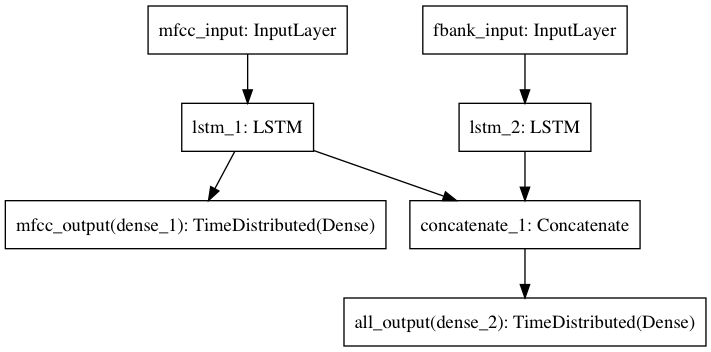

In [12]:
Image(filename='model.png') 

In [13]:
model.fit(X_train, y_train, steps_per_epoch=10, epochs=100)

Epoch 1/100
10/10 [==============================] - 4s 422ms/step - loss: 0.6444 - mfcc_output_loss: 0.3242 - all_output_loss: 0.3202 - mfcc_output_acc: 0.8971 - all_output_acc: 0.8939
Epoch 2/100
10/10 [==============================] - 3s 259ms/step - loss: 0.4830 - mfcc_output_loss: 0.2449 - all_output_loss: 0.2381 - mfcc_output_acc: 0.9305 - all_output_acc: 0.9299
Epoch 3/100
10/10 [==============================] - 3s 270ms/step - loss: 0.4641 - mfcc_output_loss: 0.2327 - all_output_loss: 0.2313 - mfcc_output_acc: 0.9299 - all_output_acc: 0.9299
Epoch 4/100
10/10 [==============================] - 2s 244ms/step - loss: 0.4526 - mfcc_output_loss: 0.2262 - all_output_loss: 0.2263 - mfcc_output_acc: 0.9299 - all_output_acc: 0.9299
Epoch 5/100
10/10 [==============================] - 2s 233ms/step - loss: 0.4434 - mfcc_output_loss: 0.2212 - all_output_loss: 0.2221 - mfcc_output_acc: 0.9301 - all_output_acc: 0.9299
Epoch 6/100
10/10 [==============================] - 2s 229ms/step - l

10/10 [==============================] - 3s 266ms/step - loss: 0.3281 - mfcc_output_loss: 0.1648 - all_output_loss: 0.1633 - mfcc_output_acc: 0.9438 - all_output_acc: 0.9386
Epoch 45/100
10/10 [==============================] - 3s 254ms/step - loss: 0.3269 - mfcc_output_loss: 0.1645 - all_output_loss: 0.1624 - mfcc_output_acc: 0.9437 - all_output_acc: 0.9390
Epoch 46/100
10/10 [==============================] - 3s 256ms/step - loss: 0.3241 - mfcc_output_loss: 0.1633 - all_output_loss: 0.1607 - mfcc_output_acc: 0.9441 - all_output_acc: 0.9392
Epoch 47/100
10/10 [==============================] - 3s 256ms/step - loss: 0.3226 - mfcc_output_loss: 0.1626 - all_output_loss: 0.1600 - mfcc_output_acc: 0.9447 - all_output_acc: 0.9394
Epoch 48/100
10/10 [==============================] - 3s 259ms/step - loss: 0.3213 - mfcc_output_loss: 0.1622 - all_output_loss: 0.1591 - mfcc_output_acc: 0.9453 - all_output_acc: 0.9398
Epoch 49/100
10/10 [==============================] - 2s 234ms/step - loss: 0.

10/10 [==============================] - 2s 219ms/step - loss: 0.2716 - mfcc_output_loss: 0.1410 - all_output_loss: 0.1306 - mfcc_output_acc: 0.9535 - all_output_acc: 0.9529
Epoch 88/100
10/10 [==============================] - 2s 222ms/step - loss: 0.2727 - mfcc_output_loss: 0.1412 - all_output_loss: 0.1316 - mfcc_output_acc: 0.9537 - all_output_acc: 0.9532
Epoch 89/100
10/10 [==============================] - 3s 257ms/step - loss: 0.2717 - mfcc_output_loss: 0.1407 - all_output_loss: 0.1310 - mfcc_output_acc: 0.9540 - all_output_acc: 0.9536
Epoch 90/100
10/10 [==============================] - 3s 299ms/step - loss: 0.2669 - mfcc_output_loss: 0.1391 - all_output_loss: 0.1277 - mfcc_output_acc: 0.9540 - all_output_acc: 0.9535
Epoch 91/100
10/10 [==============================] - 3s 296ms/step - loss: 0.2670 - mfcc_output_loss: 0.1388 - all_output_loss: 0.1281 - mfcc_output_acc: 0.9543 - all_output_acc: 0.9543
Epoch 92/100
10/10 [==============================] - 3s 264ms/step - loss: 0.

In [75]:
model.save('model.hdf5')

# Test
### AUC

In [77]:
if not NOISE:
    y_pred = model.predict(X_test)[1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    print(auc(fpr, tpr))

0.904180660104


In [28]:
if NOISE:
    y_pred = model.predict(X_test)[1]
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    print(auc(fpr, tpr))

0.868059351815697


### Example

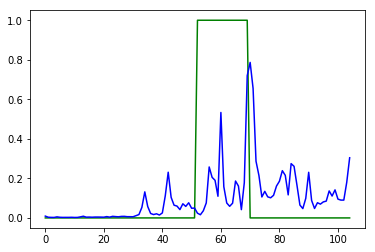

In [25]:
if not NOISE:
    y_pred = model.predict(X_test)
    sname= np.argsort(y_test[:, :, -1].mean(axis=1))[-1]
    plt.plot(np.arange(NUM_IN_SNAME),  y_test[sname, :, -1], 'g')
    plt.plot(np.arange(NUM_IN_SNAME), y_pred[1][sname, :, -1], 'b')
    plt.show()

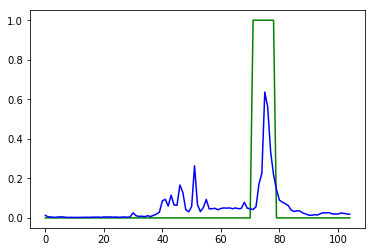

In [30]:
if NOISE:
    y_pred = model.predict(X_test)
    sname= np.argsort(y_test[:, :, -1].mean(axis=1))[-1]
    plt.plot(np.arange(NUM_IN_SNAME),  y_test[sname, :, -1], 'g')
    plt.plot(np.arange(NUM_IN_SNAME), y_pred[1][sname, :, -1], 'b')
    plt.show()

### Score of other algo
(NN -- the best :)

In [17]:
def test_models(models_with_names, X, y, predict_fun, n_splits=5):
    for clf, name in models_with_names:
        print('{0: <20}'.format(name), end='')
        aucs = []
        skf = StratifiedKFold(n_splits=n_splits, random_state=42)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            y_pred = predict_fun(clf, X_test)
            auc = metrics.roc_auc_score(y_test, y_pred)
            aucs.append(auc)
        auc = np.mean(aucs)
        print("AUC:", auc)

def test_all_sklearn(X, y):
    scaler = MinMaxScaler()
    print("\nCurrent scaler", scaler, end="\n\n")
    X_scaled = scaler.fit_transform(X)
    models_with_names = ((MultinomialNB(), "MultinomialNB"),
                         (BernoulliNB(), "BernoulliNB"))

    test_models(models_with_names, X_scaled, y, lambda clf, x: clf.predict_proba(x)[:, 1])

    for scaler in [MinMaxScaler(), StandardScaler()]:
        print("\nCurrent scaler", scaler, end="\n\n")

        X_scaled = scaler.fit_transform(X)
        models_with_names = ((RidgeClassifier(), "Ridge Classifier"),
                             (Perceptron(), "Perceptron"),
                             (PassiveAggressiveClassifier(), "Passive-Aggressive"),
                             (SGDClassifier(), "LinearSVC"),
                             (SGDClassifier(), "SGDClassifier"),
                             (LinearSVC(), "LinearSVC"))

        test_models(models_with_names, X_scaled, y, lambda clf, x: clf.decision_function(x))

        models_with_names = (
            (xgb.XGBClassifier(), "XGBoost")
            , (RandomForestClassifier(), "Random forest"))

        test_models(models_with_names, X_scaled, y, lambda clf, x: clf.predict_proba(x)[:, 1], n_splits=2)

only_features = r.iloc[:, :nfeatures]
X = only_features.as_matrix()
y = r.IS_LAUGHTER.as_matrix()
test_all_sklearn(X, y)


Current scaler MinMaxScaler(copy=True, feature_range=(0, 1))

MultinomialNB       AUC: 0.788444678066
BernoulliNB         AUC: 0.502392078071

Current scaler MinMaxScaler(copy=True, feature_range=(0, 1))

Ridge Classifier    AUC: 0.858725344402
Perceptron          

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/

AUC: 0.748844692209
Passive-Aggressive  AUC: 0.846300400041
LinearSVC           AUC: 0.77330015169
SGDClassifier       AUC: 0.849760179177
LinearSVC           AUC: 0.850947694978
XGBoost             AUC: 0.780945577695
Random forest       AUC: 0.741997751735

Current scaler StandardScaler(copy=True, with_mean=True, with_std=True)

Ridge Classifier    AUC: 0.854702124435
Perceptron          AUC: 0.706223105128
Passive-Aggressive  AUC: 0.729812964536
LinearSVC           

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/

AUC: 0.834147643166
SGDClassifier       AUC: 0.746679759972
LinearSVC           AUC: 0.836022378088
XGBoost             AUC: 0.780945577695
Random forest       AUC: 0.750225425534
